# Appendix: Python Code

This notebook contains the code used for the exam project of group 35. The following topics are covered:

* Data collection 
* Sentiment analysis of Swedish Riksbank Minutes 
* Machine learning model for predicting stock market

## Data Collection

Data was collected from three sources:

1. [**Swedish Riksbank:**](https://www.riksbank.se/) Minutes of the Executive Board's monetary policy meetings and repo rate data
2. [**NASDAQ OMX NORDIC:**](http://www.nasdaqomxnordic.com/indexes/historical_prices?Instrument=SE0000337842) Stock market index
3. [**The Federal Reserve:**](https://www.federalreserve.gov/econres/notes/ifdp-notes/constructing-a-dictionary-for-financial-stability-20170623.htm) Dictionary for sentiment analysis

### Extracting PDF content from Minutes

The minutes from the monetary policy meetings are published in PDF format. In order to extract the content we used the package [PYPDF2](https://pypi.org/project/PyPDF2/). As a first step we defined a function for preprocessing that takes *string* as an input and returns it in lower case and tokenized. Secondly we needed a function (pdf_extractor) that would extract the PDF:s and return the results as lists separated per page. 

In [45]:
#Necessary imports
import PyPDF2
import requests
import numpy as np, seaborn as sns, pandas as pd
import nltk, nltk.sentiment, sklearn
import urllib.request

import re, ast, datetime

import collections
from collections import Counter

from os import path
import os, json
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [29]:
#convert list to pd.series

#Preprocessing - tokenize and lower case pdf-strings
tokenizer = nltk.tokenize.TweetTokenizer()
def preprocessing(string):
    string = string.lower()
    string = tokenizer.tokenize(string)
    return string

#Apply positive/negative sets on pdf-string
#tok_doc1 = doc1_str.apply(preprocessing)
def count_dictionary(document_elem, dictionary):
    lst = []
    for word in document_elem:
        if (word in dictionary):
            lst.append(word)
    return len(lst)

#Apply positive/negative sets on pdf-string
def apply_dictionary(document_elem, dictionary):
    lst = []
    for word in document_elem:
        if (word in dictionary):
            lst.append(word)
    return [lst]

#PDF extractor script. Creates a list separated per page.
def pdf_extractor(path):
    pdf_file = open(path, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))
    res1 = []
    for i in range(len(c)):
        page = read_pdf.getPage(i)
        page_content = page.extractText()
        res1.append(page_content)
    return res1

In [41]:
# A dictionary of each file has been loaded as a json file.
# A much quicker way to load the text data, than PDF_str()
r = requests.get("https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/PDFs.json")

PDFs = r.json()
   


In [53]:
#Sebastian file path
#basedir = r'C:\Users\sebag\Documents\GitHub\SDS Group 35\Exam_Project\Minutes_PDF'

#Annalisa file path
#basedir = r'C:\Users\na95\OneDrive\Documenti\GitHub\SDS-Group-35\Exam_Project\Minutes_PDF'

#Matias file path
basedir = r'/Users/matias/Documents/SDS-Group-35/Exam_Project/Minutes_PDF'

In [ ]:
###-------------------------------------------------------###
### NOT NECESSARY TO RUN. THIS CODE CREATES THE JSON FILE ###
###-------------------------------------------------------###

# Make sure to use the right file path!
# The function returns a dictionary containing: {file name: list of every word in the file}
# PDFs is compatible for the dic_wordcounting function

def PDF_str(path):
    i = 0
    docs = []
    file_names = []
    for fn in os.listdir(path):
        print('Now treating file: ' + fn + '\nDocument no.: ' + str(i+1))
        doc = pdf_extractor(path + ('/' if path[:3] == 'http' else '\\') + fn)
        doc = pd.Series([''.join(doc)])
        doc = doc.apply(preprocessing)
        i += 1

        docs.append(doc[0])
        file_names.append(fn)
        
    file_dict = dict(zip(file_names, docs))
    # print(type(docs))
    return file_dict

PDFs = PDF_str(basedir)

In [42]:
def neu_count(neu, PDF_dl):
    neu_words = []
    i = 0
    error = []
    
    for words in PDF_dl.values():
        try:
            neu_words.append(apply_dictionary(words, neu))
            error.append(False)

            i += 1

            #date = re.findall(r'\d+', fn)
        except KeyError:
            neu_words.append(np.NaN)
            error.append(True)
            i += 1
        
    df = pd.DataFrame(neu_words)
    return df

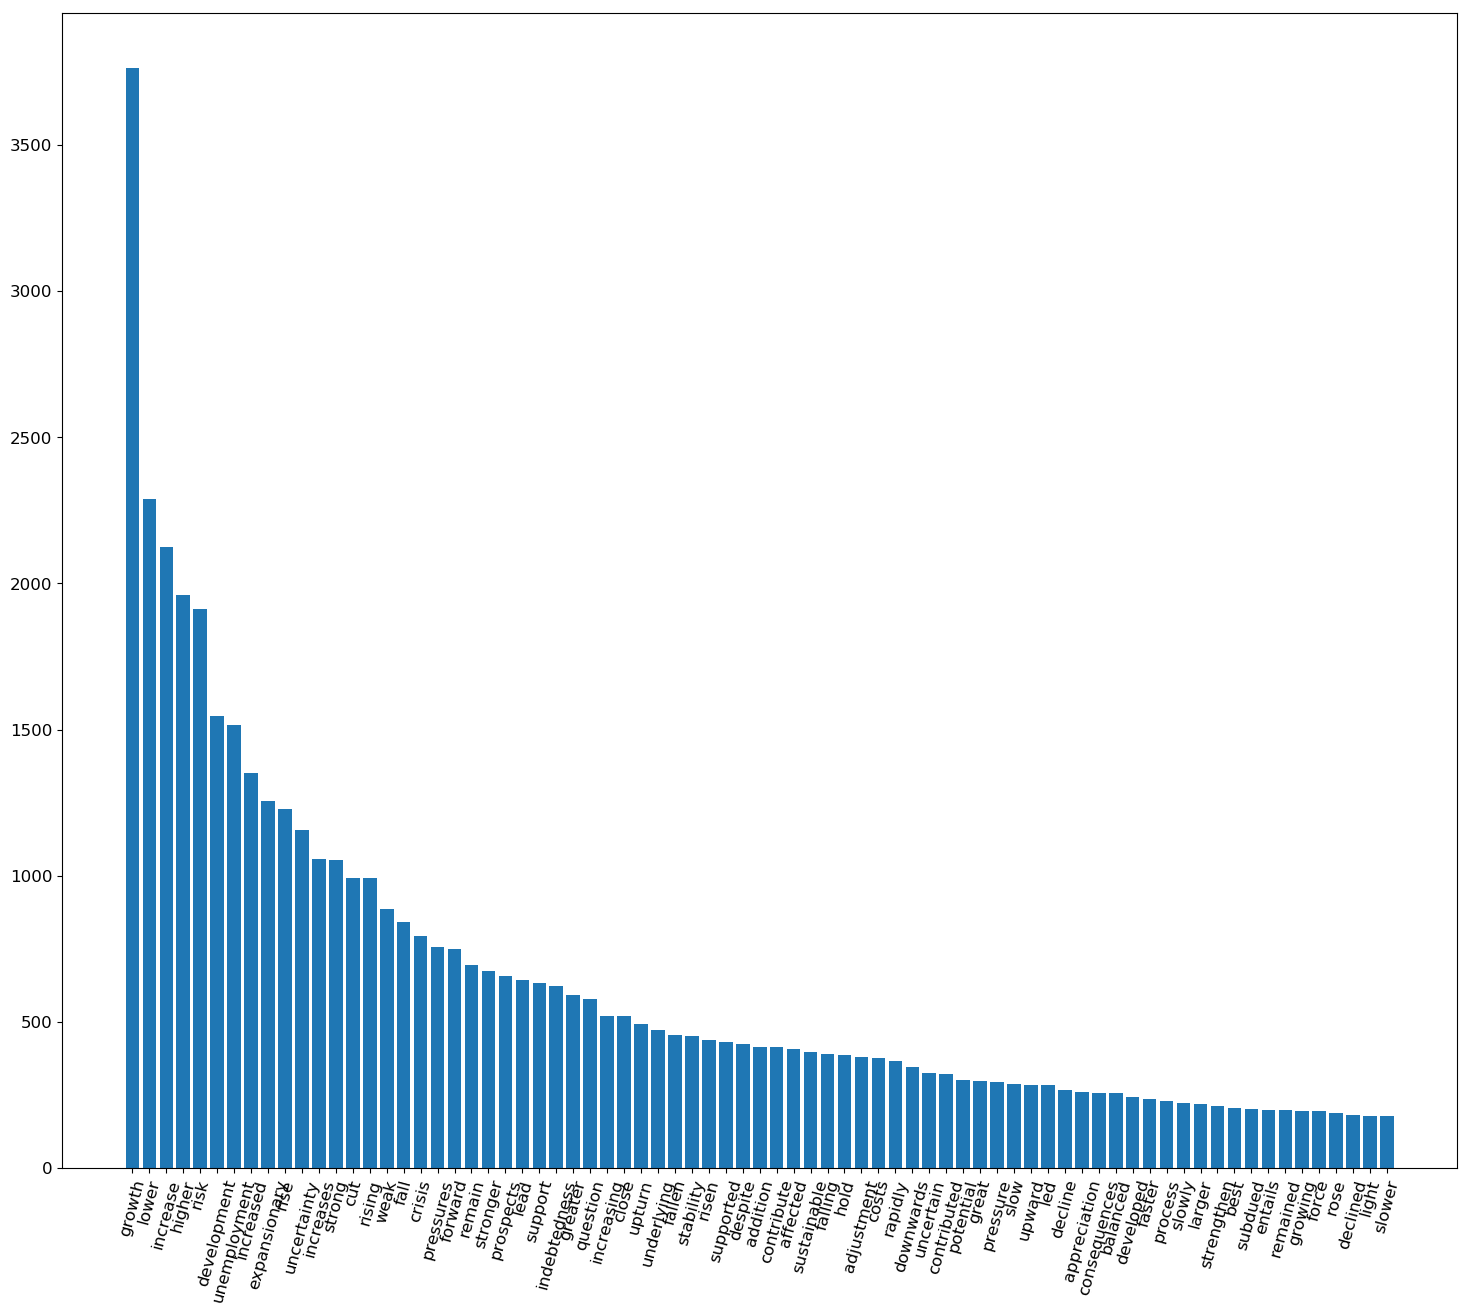

{'growth': 3762, 'lower': 2288, 'increase': 2123, 'higher': 1959, 'risk': 1914, 'development': 1545, 'unemployment': 1516, 'increased': 1350, 'expansionary': 1255, 'rise': 1228, 'uncertainty': 1156, 'increases': 1058, 'strong': 1054, 'cut': 994, 'rising': 993, 'weak': 886, 'fall': 841, 'crisis': 793, 'pressures': 756, 'forward': 748, 'remain': 695, 'stronger': 674, 'prospects': 658, 'lead': 645, 'support': 632, 'indebtedness': 624, 'greater': 593, 'question': 579, 'increasing': 521, 'close': 519, 'upturn': 494, 'underlying': 474, 'fallen': 454, 'stability': 453, 'risen': 437, 'supported': 430, 'despite': 425, 'addition': 415, 'contribute': 413, 'affected': 409, 'sustainable': 397, 'falling': 391, 'hold': 386, 'adjustment': 381, 'costs': 376, 'rapidly': 368, 'downwards': 345, 'uncertain': 327, 'contributed': 321, 'potential': 300, 'great': 297, 'pressure': 294, 'slow': 288, 'upward': 284, 'led': 284, 'decline': 269, 'appreciation': 259, 'consequences': 257, 'balanced': 256, 'developed':

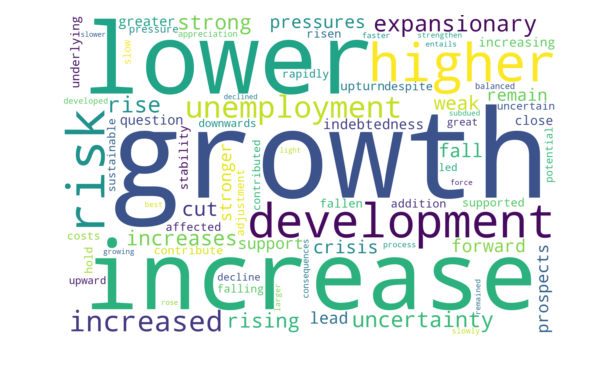

In [46]:
# Takes inputs:
    # - lexicon: A set of words, which will be applied on the PDF-files
    # - PDF_dl: Dictionary. Created for the purpose to treat PDFs
    # - n: (int) The n most common words will be added to the dictionary
    # - Word_Cloud: If a wordcloud is wanted, write: 1, as input. Creates a wordcloud with n words based on the frequency
# Returns:
    # - A dictionary containing the n most common words as keys, and the frequency of the word as values

def dic_wordcounting(lexicon, PDF_dl, n, Word_Cloud):
    
    wordc_df = neu_count(lexicon, PDF_dl)
    
    wordc_dic = Counter([])
    for elem in wordc_df[0]:
        a = Counter(elem)
        wordc_dic = wordc_dic + a
        
    wordc_dic = dict(sorted(wordc_dic.items(), key = lambda x: x[1], reverse = True))
    
    wordc_lst = list(wordc_dic.items())
    del wordc_lst[n:]
    wordc_dic = dict(wordc_lst)
    
    
    plt.style.use('default')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['lines.markersize'] = 4
    plt.figure(figsize=(18, 15))
    
    plt.bar(range(len(wordc_dic)), list(wordc_dic.values()), align='center')
    plt.xticks(range(len(wordc_dic)), list(wordc_dic.keys()), rotation = 75)
    plt.show()
    #plt.savefig('Frequency_neu_words.png')
    
    print(wordc_dic)
    
    if Word_Cloud == 1:
        wc = WordCloud(background_color="white",width=2000,height=1300,relative_scaling=0.5,normalize_plurals=False, random_state = 2).generate_from_frequencies(wordc_dic)
        
        plt.axis("off")
        plt.figure
        plt.imshow(wc, interpolation='bilinear')
        #plt.savefig('Wordcloud_basic_n75.png')
        plt.show()
    return wordc_dic

count_dict = dic_wordcounting(neu_words, PDFs, 75, 1)

# Creating Sentiment Variable

When creating the tone ratio, we create a counter of each positive and negative word in the dictionary values, which contains every word from the respective file.

In [47]:
# We create a two sets of words that can be applied on the words from each file

path_positive = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/positive.csv'
path_negative = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/negative.csv'
positive_cb = pd.read_csv(path_positive, sep=';', header=None)
negative_cb = pd.read_csv(path_negative, sep=';', header=None)
positive_cb = set(positive_cb[0])
negative_cb = set(negative_cb[0])


In [48]:
url = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/bow_ny.csv'

neu_df = pd.read_csv(url, delimiter = ';')
neu_words = set(neu_df['Word'])
len(neu_words)

1093

In [49]:
def sentiment_analysis(pos, neg, PDFs_dict):
    pos_words = []
    neg_words = []
    average_tone = []
    i = 0
    error = []
    
    for words in PDFs_dict.values():
        try:

            pos_words.append(int(count_dictionary(words, pos)))
            neg_words.append(int(count_dictionary(words, neg)))
            average_tone.append((pos_words[i]-neg_words[i])/len(words))
            error.append(False)  
            
            i += 1
        
        except KeyError:
            error.append(True)
            pos_words.append(np.NaN)
            neg_words.append(np.NaN)
            average_tone.append(np.NaN)
            
            i += 1
            
        #date = re.findall(r'\d+', fn)
    df = pd.DataFrame(list(zip(pos_words, neg_words, average_tone, error)))
    return df

sent_df = sentiment_analysis(positive_cb, negative_cb, PDFs)
sent_df.columns = ['Number of positive words', 'Number of negative words', 'Average tone ratio', 'Error in processing PDF']

In [50]:
# saving the sentiment analysis
sent_df.to_csv('sentimentonourdata.csv')

# Create key from filenames
The key is used for combining Minutes sentiment variables to the other variables, based on the date.

In [54]:
files = []
files2 = []

# r=root, d=directories, f = files
for r, d, f in os.walk(basedir):
    for file in f:
        if '.pdf' in file:
            files.append('20' + file[3:5] + "-" + file[5:7] + "-" + file[7:9])
            files2.append(file)

Final_list = {'Dato':files,'Filnavn':files2}

df_files = pd.DataFrame(Final_list)
df_files['date_time'] = pd.to_datetime(df_files['Dato'])
df_files['date'] = pd.to_datetime(df_files['Dato']) + pd.DateOffset(days=1)
df_files.head()

,Dato,Filnavn,date_time,date
0,2011-04-19,ppp110419e.pdf,2011-04-19,2011-04-20
1,2012-12-17,ppp121217e.pdf,2012-12-17,2012-12-18
2,2001-09-17,ppp010917e.pdf,2001-09-17,2001-09-18
3,2010-10-25,ppp101025e.pdf,2010-10-25,2010-10-26
4,2002-03-18,ppp020318e.pdf,2002-03-18,2002-03-19


In [55]:
sent_df = pd.concat([sent_df, pd.Series(df_files['date'])], axis = 1, join = 'inner')
sent_df.head()

,Number of positive words,Number of negative words,Average tone ratio,Error in processing PDF,date
0,30,35,-0.000822,False,2011-04-20
1,11,19,-0.001847,False,2012-12-18
2,20,25,-0.001100,False,2001-09-18
3,12,21,-0.002571,False,2010-10-26
4,12,28,-0.003221,False,2002-03-19


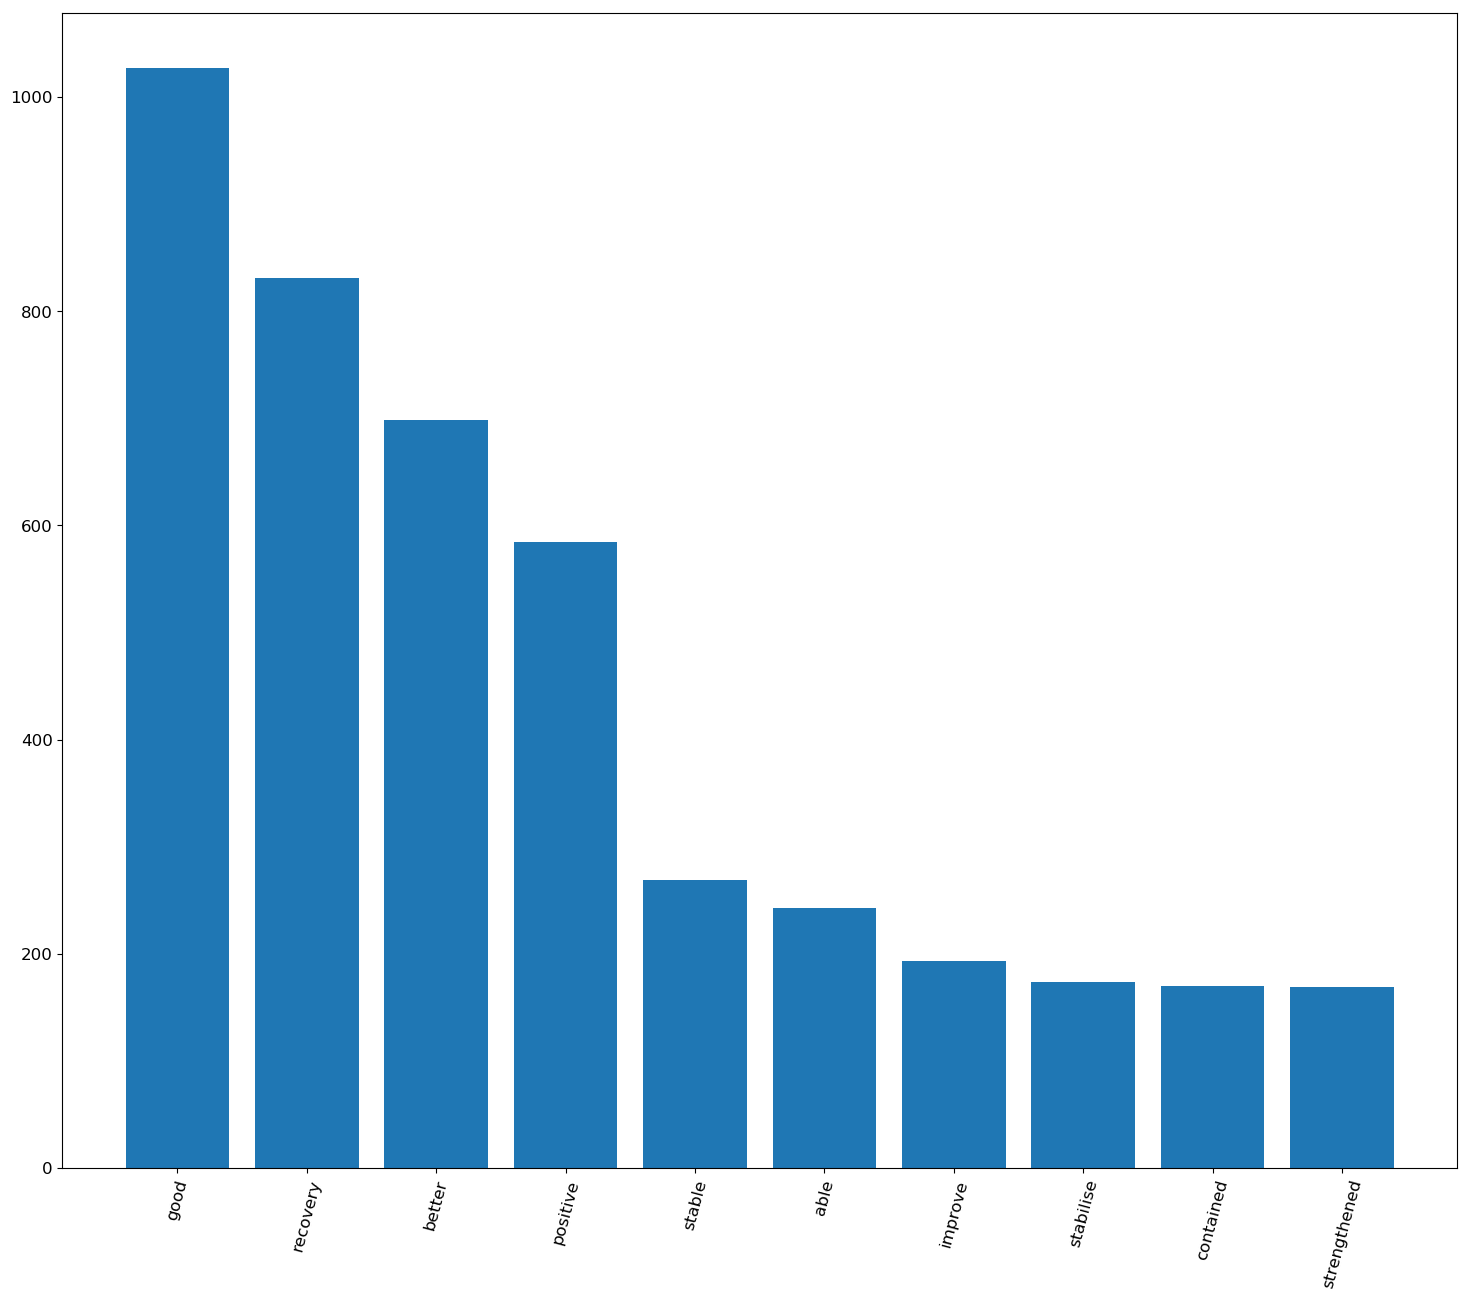

{'good': 1027, 'recovery': 831, 'better': 698, 'positive': 585, 'stable': 269, 'able': 243, 'improve': 193, 'stabilise': 174, 'contained': 170, 'strengthened': 169}


/Users/matias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [56]:
new_dict_pos = dic_wordcounting(positive_cb, PDFs, 10, 0)

new_dict_sorted_pos = dict(sorted(new_dict_pos.items(), key = lambda x: x[1], reverse = True))
new_dict_sorted_pos

row_list_pos = [fn for fn in os.listdir(basedir)]
column_list_pos = new_dict_sorted_pos

#['imf', 'ecb', 'unemployment', 'appreciation', 'depreciation', 'deflation', 'inflation', 'debt', 'unchanged', 'fed', 'federal', 'crisis', 'germany', 'greece', 'usa']

df_pos = []
df_pos = pd.DataFrame(columns = column_list_pos, index = row_list_pos)

m = 0
for i in row_list_pos:
    for j in column_list_pos:
        df_pos.ix[i,j] = list(PDFs.values())[m].count(j)
    m = m + 1
    
df_pos['År'] = pd.to_datetime(files).year

(array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]),
 <a list of 20 Text xticklabel objects>)

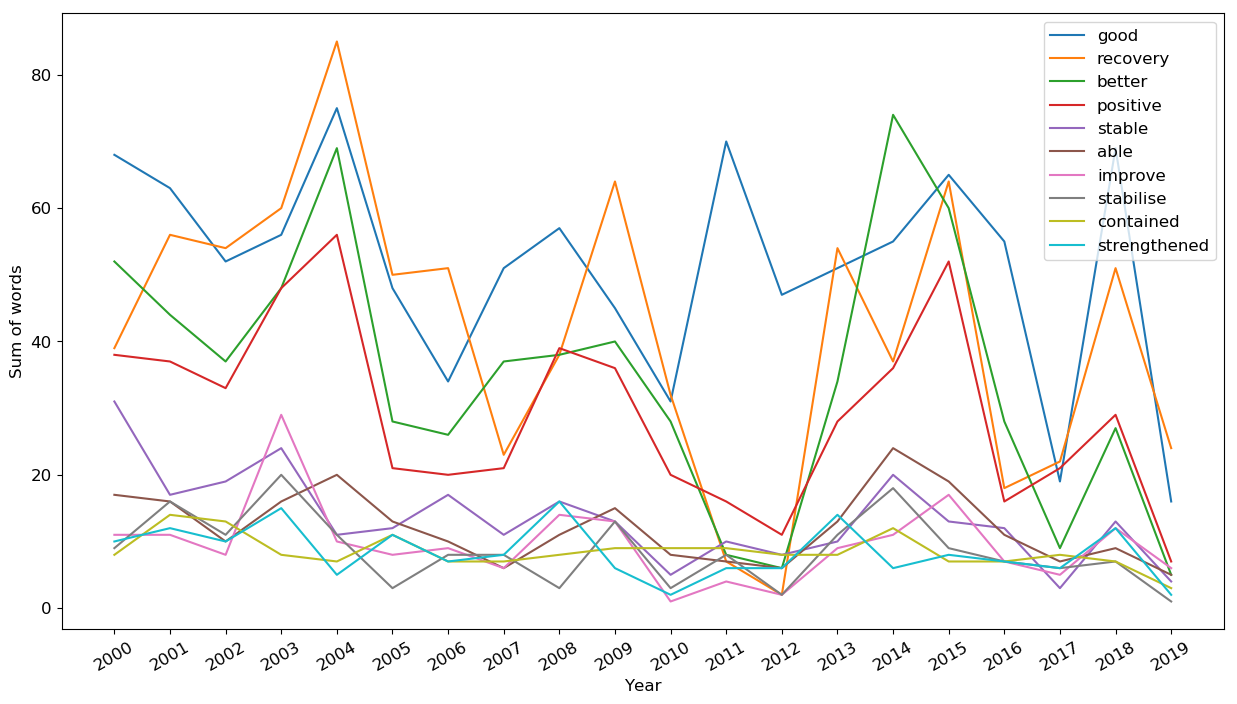

In [57]:
df_pos_sum = df_pos.groupby(['År']).sum()

ax = df_pos_sum.plot.line(figsize = (15, 8))
ax.set_xlabel("Year")
ax.set_ylabel("Sum of words")
ax.set_xticks(ticks=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
plt.xticks(rotation=30)

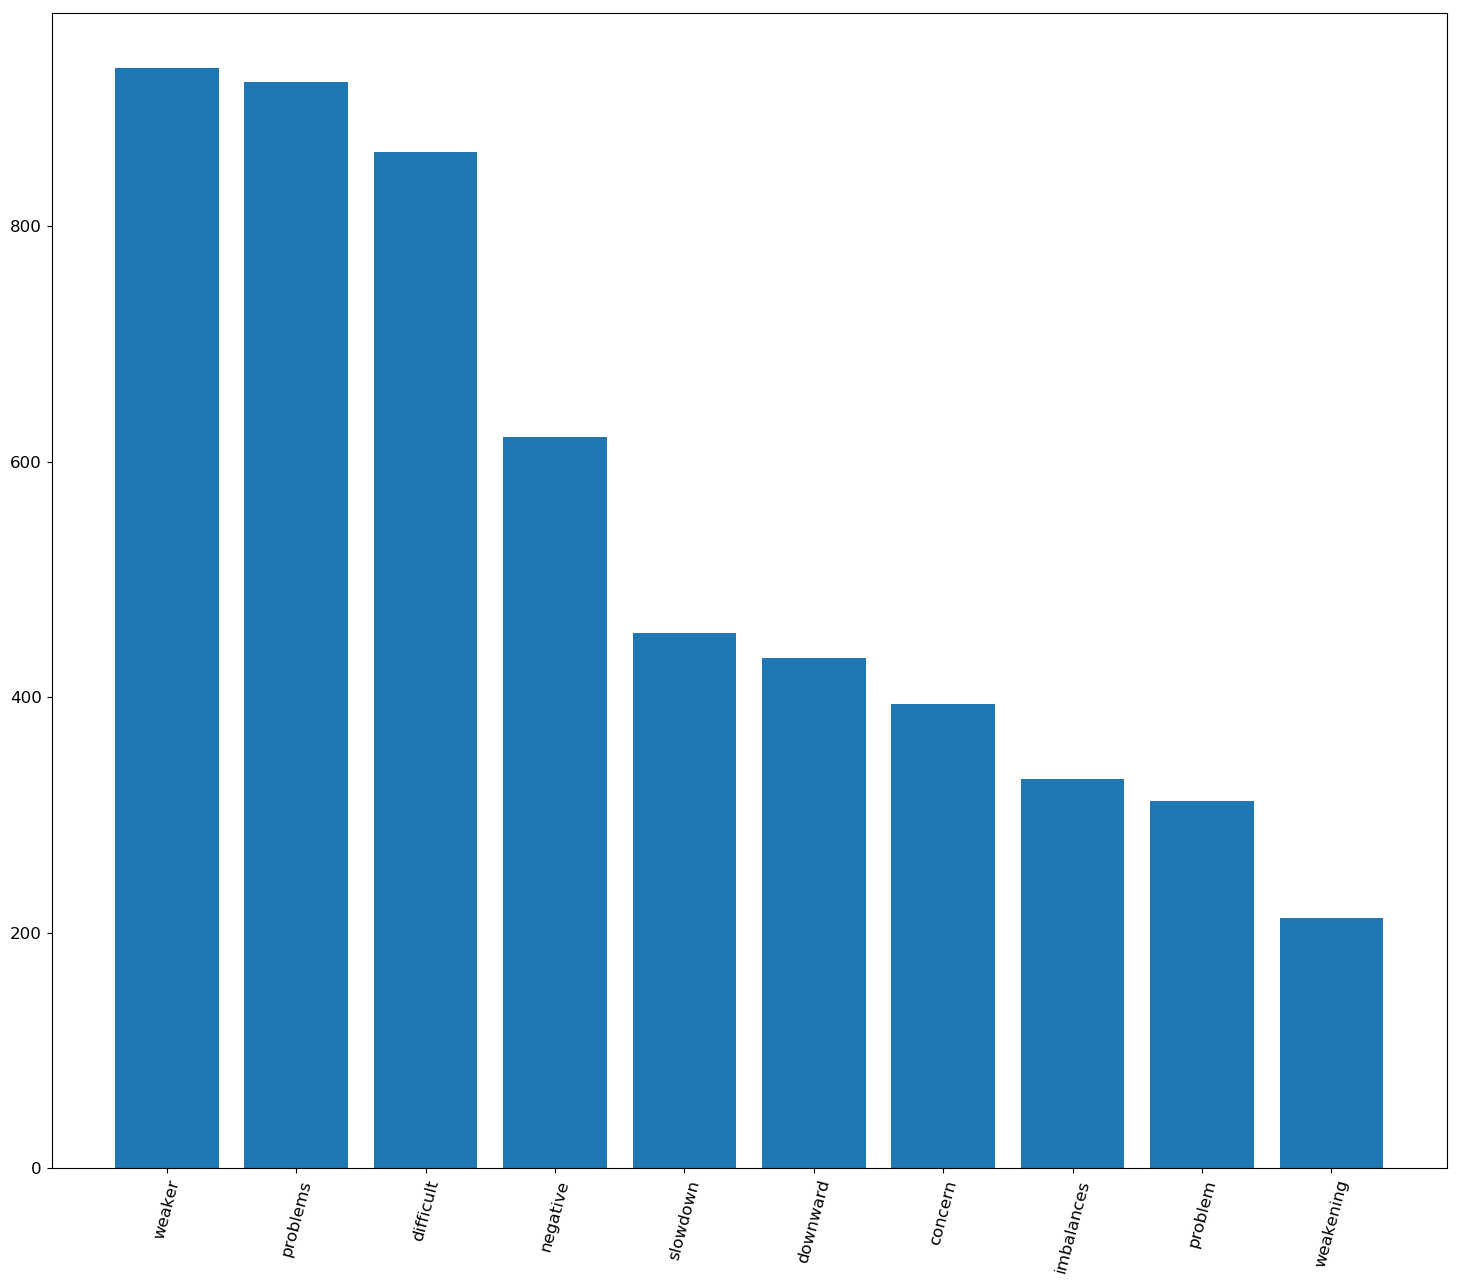

{'weaker': 934, 'problems': 922, 'difficult': 863, 'negative': 621, 'slowdown': 454, 'downward': 433, 'concern': 394, 'imbalances': 330, 'problem': 312, 'weakening': 212}


/Users/matias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [58]:
new_dict_neg = dic_wordcounting(negative_cb, PDFs, 10, 0)

new_dict_sorted_neg = dict(sorted(new_dict_neg.items(), key = lambda x: x[1], reverse = True))
new_dict_sorted_neg

row_list_neg = [fn for fn in os.listdir(basedir)]
column_list_neg = new_dict_sorted_neg

#['imf', 'ecb', 'unemployment', 'appreciation', 'depreciation', 'deflation', 'inflation', 'debt', 'unchanged', 'fed', 'federal', 'crisis', 'germany', 'greece', 'usa']

df_neg = []
df_neg = pd.DataFrame(columns = column_list_neg, index = row_list_neg)

m = 0
for i in row_list_neg:
    for j in column_list_neg:
        df_neg.ix[i,j] = list(PDFs.values())[m].count(j)
    m = m + 1
    
df_neg['År'] = pd.to_datetime(files).year

(array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]),
 <a list of 20 Text xticklabel objects>)

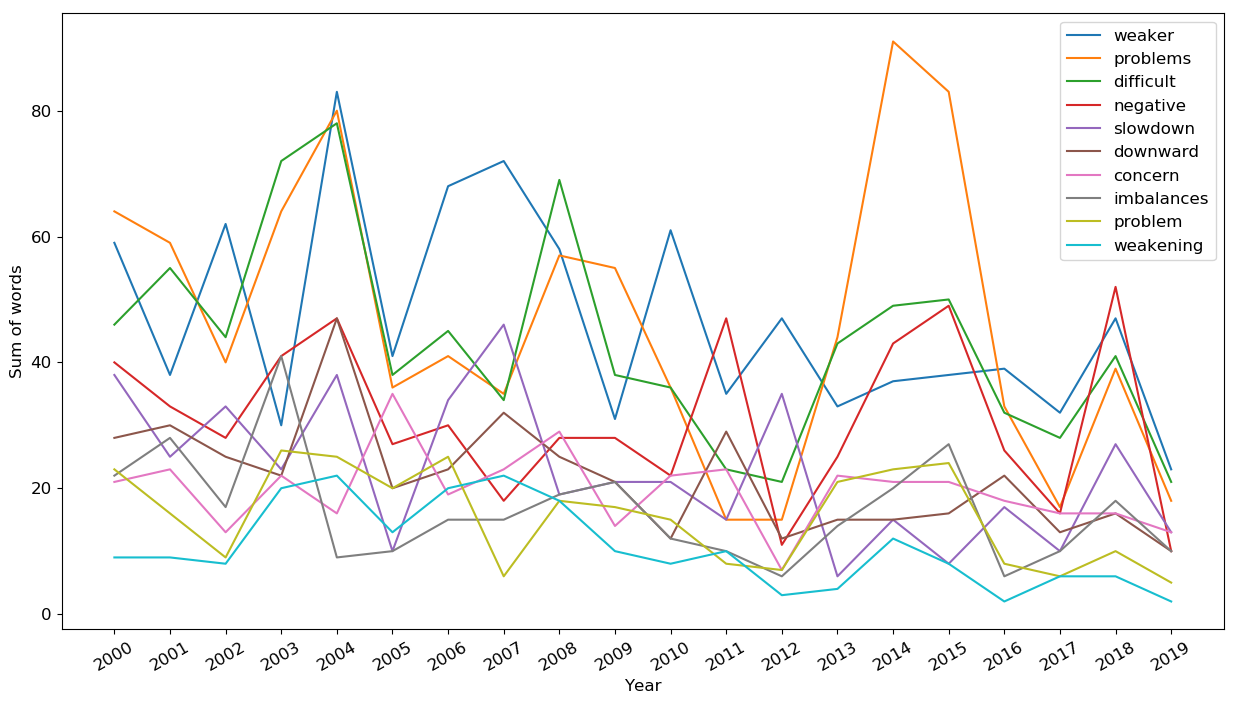

In [59]:
df_neg_sum = df_neg.groupby(['År']).sum()

import matplotlib.pyplot as plt

ax2 = df_neg_sum.plot.line(figsize = (15, 8))
ax2.set_xlabel("Year")
ax2.set_ylabel("Sum of words")
ax2.set_xticks(ticks=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
plt.xticks(rotation=30)

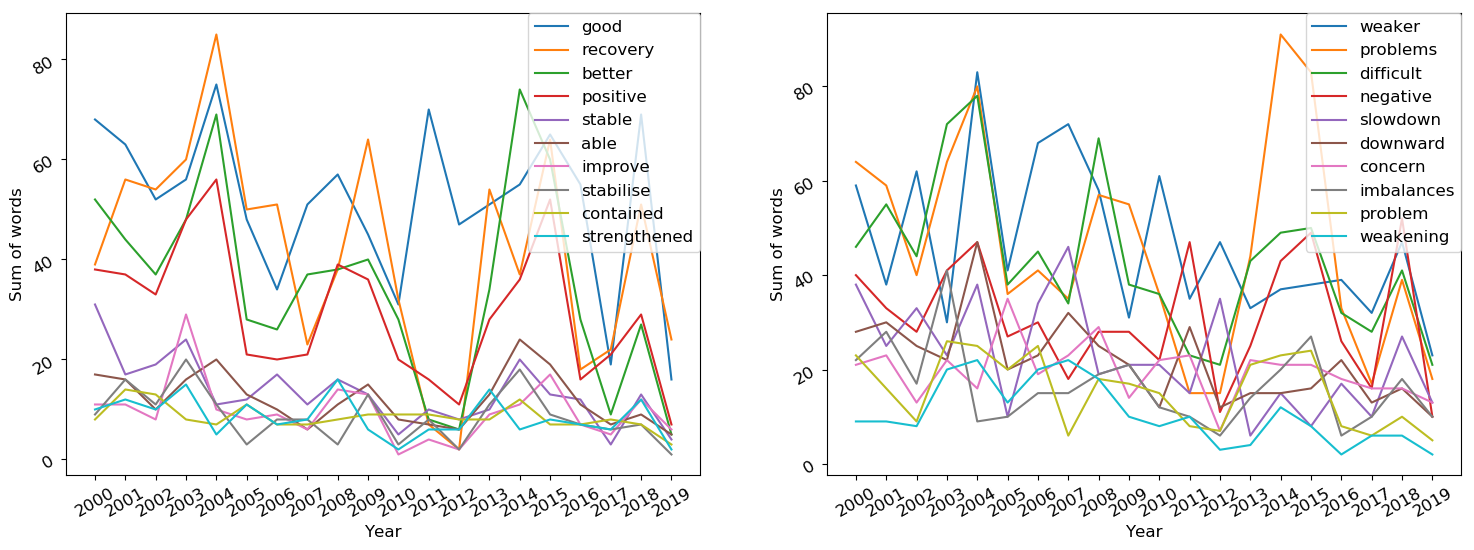

In [60]:
f, axes = plt.subplots(1, 2, figsize = (18,6))

ax1 = df_pos_sum.plot.line(ax = axes[0])
ax1.set_xlabel("Year")
ax1.set_ylabel("Sum of words")
ax1.set_xticks(ticks=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
ax1.tick_params(labelrotation=30)
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)

ax2 = df_neg_sum.plot.line(ax = axes[1])
ax2.set_xlabel("Year")
ax2.set_ylabel("Sum of words")
ax2.set_xticks(ticks=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
ax2.tick_params(labelrotation=30)
ax2.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)

<Figure size 640x480 with 0 Axes>

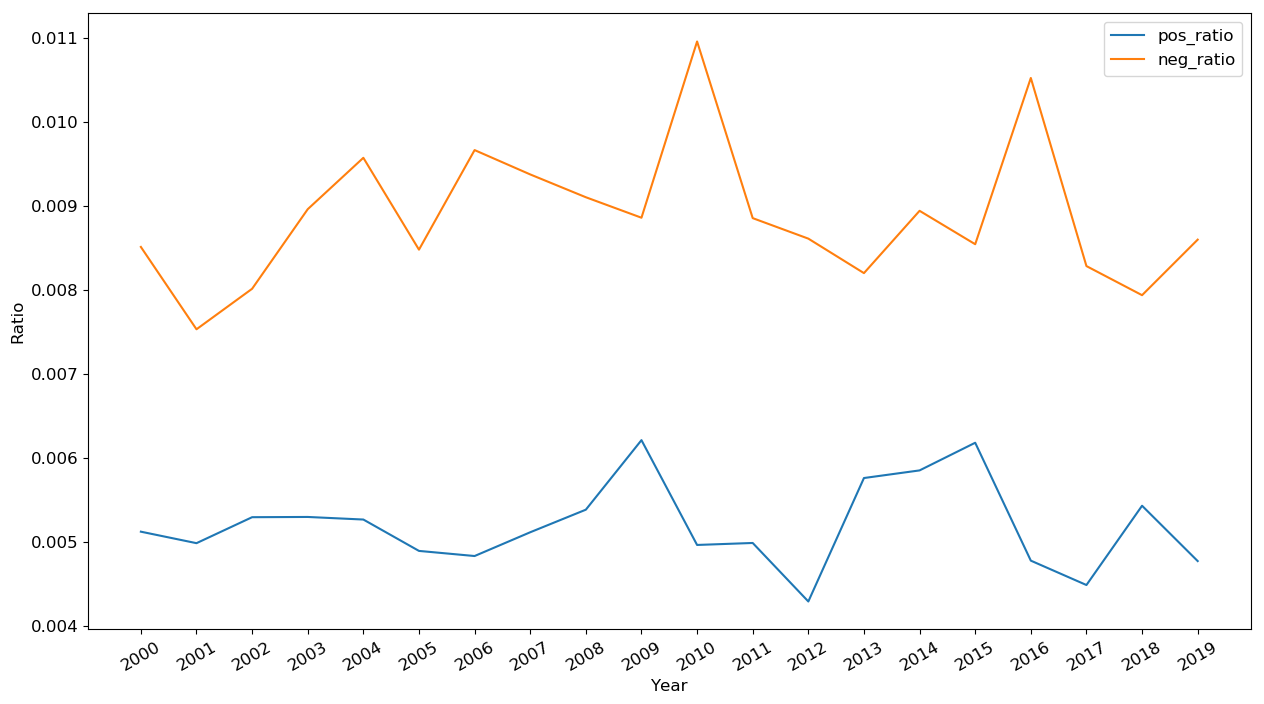

<Figure size 640x480 with 0 Axes>

In [61]:
row_list = [fn for fn in os.listdir(basedir)]
pos_word_count = []
neg_word_count = []

total_count = []

df_final = []
df_final = pd.DataFrame(index = row_list)

m = 0
for i in row_list:
    pos_count = 0
    neg_count = 0

    for word in list(PDFs.values())[m]:
        pos_count = pos_count + (list(positive_cb).count(word))
        neg_count = neg_count + (list(negative_cb).count(word))
        
    pos_word_count.append(pos_count)
    neg_word_count.append(neg_count)
    
    total_count.append(len(list(PDFs.values())[m]))
    
    m = m + 1
    
df_final['År'] = pd.to_datetime(files).year
df_final['pos_word_count'] = pos_word_count
df_final['neg_word_count'] = neg_word_count
df_final['total_count'] = total_count
df_final

df_final_posneg = df_final.groupby(['År']).sum()
df_final_posneg['pos_ratio'] = df_final_posneg['pos_word_count'] / df_final_posneg['total_count']
df_final_posneg['neg_ratio'] = df_final_posneg['neg_word_count'] / df_final_posneg['total_count']

new_df_posneg = df_final_posneg[['pos_ratio', 'neg_ratio']].copy()

import matplotlib.pyplot as plt

ax3 = new_df_posneg.plot.line(figsize = (15, 8))
ax3.set_xlabel("Year")
ax3.set_ylabel("Ratio")
ax3.set_xticks(ticks=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
plt.xticks(rotation=30)
plt.figure()

<function matplotlib.pyplot.show(*args, **kw)>

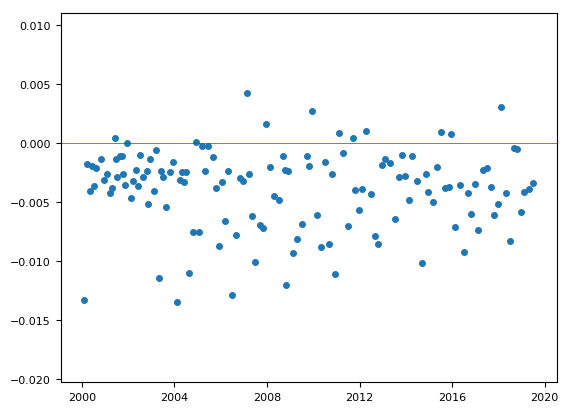

In [62]:
plt.rcParams['figure.figsize'] = (9,4)
plt.style.use('default')
plt.rcParams.update({'font.size': 8})
plt.rcParams['lines.markersize'] = 4

x = np.array(sent_df['date'])
y = np.array(sent_df['Average tone ratio'])

plt.scatter(x, y)
plt.axhline(y = 0, color = 'r', linestyle = '-', linewidth = 0.5)
# plt.savefig('Sentiment_scatter.png')
plt.show

In [63]:
# summary statistics of the tone

sent_df['Average tone ratio'].describe()

count    135.000000
mean      -0.003858
std        0.003364
min       -0.013422
25%       -0.005773
50%       -0.003246
75%       -0.001805
max        0.004220
Name: Average tone ratio, dtype: float64

### Collecting Stockmarket data

In [65]:
path_omx = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/historic_data/omx30.csv'
cols = ['date', 'closing value']
omx = pd.read_csv(path_omx, sep=';', names = cols)

In [66]:
#opening value column
omx['opening value'] = omx['closing value'].shift(-1)
omx['date'] = pd.to_datetime(omx['date'])


#Difference between opening and closing value
omx['dif abs'] = omx['closing value'] - omx['opening value']
omx['dif frac'] = (omx['closing value']-omx['opening value']) / omx['opening value']

#Difference between opening and closing + 14/30 d

omx['dif +30d'] = (omx['closing value'].shift(+30)-omx['opening value']) / omx['opening value']
omx['dif +14d'] = (omx['closing value'].shift(+14)-omx['opening value']) / omx['opening value']

#Difference between opening and closing - 14/30 d

#omx['dif -30d'] = omx['closing value'].shift(-30) / omx['opening value']
#omx['dif -14d'] = omx['closing value'].shift(-14) / omx['opening value']

omx = omx.iloc[::-1]

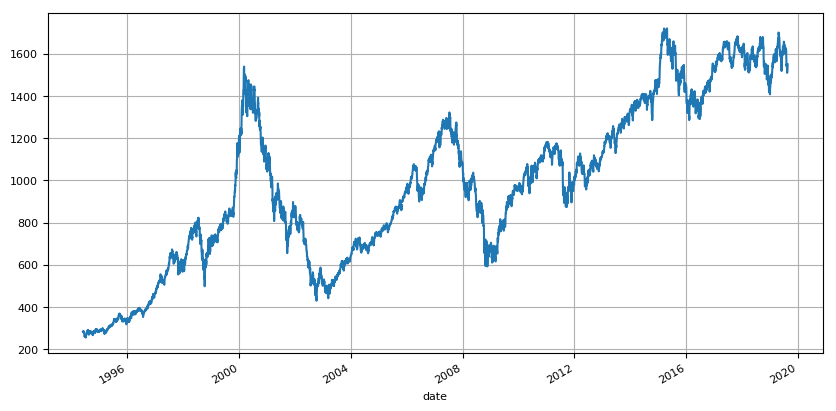

In [67]:
omx.drop(omx.loc[omx['closing value']==0].index, inplace=True)
omx.plot('date', 'closing value', grid = True, legend = False, figsize=(10, 5))
# plt.savefig('omx.png')

### Collecting Repo data

In [68]:

#import repo
path_repo = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/historic_data/reporate.csv'
cols = ['date', 'repoann', 'repoeff']
repo = pd.read_csv(path_repo, sep=';', error_bad_lines=False, names = cols)
repo['date'] = pd.to_datetime(repo['date'])

In [69]:
#change in repo column
repo['repo_ch'] = repo['repoann']-repo['repoeff']

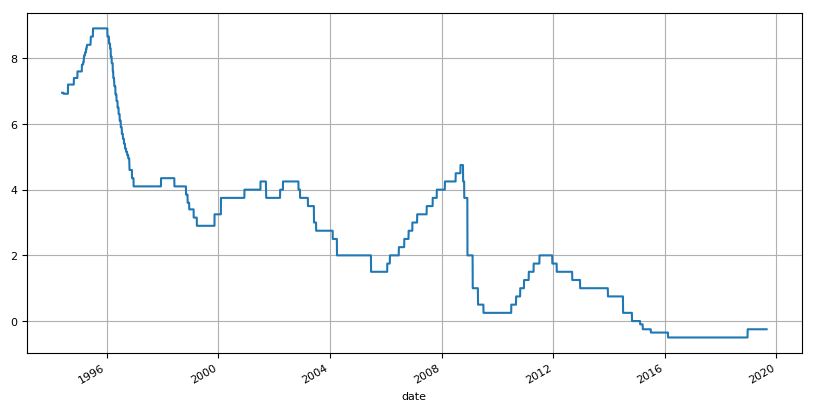

In [70]:
repo.plot('date', 'repoann', grid = True, legend = False, figsize=(10, 5))
# plt.savefig('repo.png')

### Merging complete dataframe

In [71]:
#Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [86]:
#Merge repo and omx
repo_omx = pd.merge(repo, omx, on = 'date', how = 'inner')


In [87]:
#Inspect and drop NaN
nan_rows = repo_omx[repo_omx.isnull().T.any().T]
repo_omx.dropna()
repo_omx.head()

,date,repoann,repoeff,repo_ch,closing value,opening value,dif abs,dif frac,dif +30d,dif +14d
0,1994-06-01,6.95,6.95,0.0,283.35,NaN,NaN,NaN,NaN,NaN
1,1994-06-02,6.95,6.95,0.0,282.32,283.35,-1.03,-0.003635,-0.032292,-0.079337
2,1994-06-03,6.95,6.95,0.0,284.12,282.32,1.80,0.006376,-0.018065,-0.064324
3,1994-06-06,6.95,6.95,0.0,286.71,284.12,2.59,0.009116,-0.021294,-0.091335
4,1994-06-07,6.95,6.95,0.0,282.07,286.71,-4.64,-0.016184,-0.023194,-0.084406


In [88]:
#merge repo_omx with sentiment analysis
complete_df = pd.merge(repo_omx, sent_df, on = 'date', how = 'inner')
complete_df.head()

,date,repoann,repoeff,repo_ch,closing value,opening value,dif abs,dif frac,dif +30d,dif +14d,Number of positive words,Number of negative words,Average tone ratio,Error in processing PDF
0,2000-02-04,3.75,3.25,0.5,1329.30,1318.61,10.69,0.008107,0.095237,0.046435,20,95,-0.013296,False
1,2000-03-23,3.75,3.75,0.0,1467.11,1496.01,-28.90,-0.019318,-0.044572,-0.072125,86,112,-0.001763,False
2,2000-05-05,3.75,3.75,0.0,1455.40,1444.50,10.90,0.007546,-0.039564,-0.064320,76,139,-0.004049,False
3,2000-06-08,3.75,3.75,0.0,1447.91,1425.15,22.76,0.015970,-0.042353,-0.073690,49,68,-0.001914,False
4,2000-07-07,3.75,3.75,0.0,1382.78,1347.35,35.43,0.026296,-0.015571,0.008120,20,37,-0.003590,False


In [89]:
complete_df.describe()

,repoann,repoeff,repo_ch,closing value,opening value,dif abs,dif frac,dif +30d,dif +14d,Number of positive words,Number of negative words,Average tone ratio
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,1.904851,1.929104,-0.024254,1069.146343,1067.741567,1.404776,0.001464,-0.000760,0.001801,47.358209,79.440299,-0.003860
std,1.681331,1.683794,0.250693,337.573992,337.164520,11.872203,0.012376,0.065897,0.045760,30.920077,43.281820,0.003376
min,-0.500000,-0.500000,-1.750000,476.200000,481.080000,-41.970000,-0.038164,-0.254721,-0.142816,4.000000,12.000000,-0.013422
25%,0.250000,0.250000,0.000000,784.842500,782.982500,-4.925000,-0.005595,-0.033184,-0.021140,22.250000,37.000000,-0.005809
50%,2.000000,2.000000,0.000000,1051.905000,1052.685000,1.145000,0.000810,0.007591,0.012754,42.500000,80.500000,-0.003234
75%,3.750000,3.750000,0.000000,1361.340000,1345.797500,7.665000,0.006567,0.041043,0.032958,63.750000,109.750000,-0.001784
max,4.750000,4.750000,0.500000,1700.350000,1686.400000,35.710000,0.042063,0.172584,0.087207,129.000000,171.000000,0.004220


In [76]:
print(round(complete_df.describe(), 4).to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &   repoann &   repoeff &   repo\_ch &  closing value &  opening value &   dif abs &  dif frac &  dif +30d &  dif +14d &  Number of positive words &  Number of negative words &  Average tone ratio \\
\midrule
count &  134.0000 &  134.0000 &  134.0000 &       134.0000 &       134.0000 &  134.0000 &  134.0000 &  134.0000 &  134.0000 &                  134.0000 &                  134.0000 &            134.0000 \\
mean  &    1.9049 &    1.9291 &   -0.0243 &      1069.1463 &      1067.7416 &    1.4048 &    0.0015 &   -0.0008 &    0.0018 &                   47.3582 &                   79.4403 &             -0.0039 \\
std   &    1.6813 &    1.6838 &    0.2507 &       337.5740 &       337.1645 &   11.8722 &    0.0124 &    0.0659 &    0.0458 &                   30.9201 &                   43.2818 &              0.0034 \\
min   &   -0.5000 &   -0.5000 &   -1.7500 &       476.2000 &       481.0800 &  -41.9700 &   -0.0382 &   -0.2547 &   -0.1428 &        

In [77]:
complete_df['dif frac'].describe(), complete_df['Average tone ratio'].describe(), complete_df['repo_ch'].describe()

(count    134.000000
 mean       0.001464
 std        0.012376
 min       -0.038164
 25%       -0.005595
 50%        0.000810
 75%        0.006567
 max        0.042063
 Name: dif frac, dtype: float64, count    134.000000
 mean      -0.003860
 std        0.003376
 min       -0.013422
 25%       -0.005809
 50%       -0.003234
 75%       -0.001784
 max        0.004220
 Name: Average tone ratio, dtype: float64, count    134.000000
 mean      -0.024254
 std        0.250693
 min       -1.750000
 25%        0.000000
 50%        0.000000
 75%        0.000000
 max        0.500000
 Name: repo_ch, dtype: float64)

[[1.         0.21641932]
 [0.21641932 1.        ]]


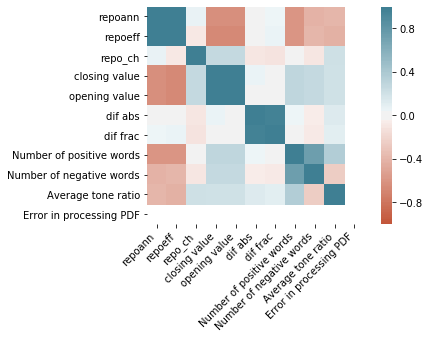

In [23]:
corr = complete_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

print(np.corrcoef(complete_df['Average tone ratio'],complete_df['repo_ch'])) # the correlation between sentiment index and
# change, if high, it means that the two variables capture a similar effect

### Dataframe quality assorance and validation

## Sentiment analysis

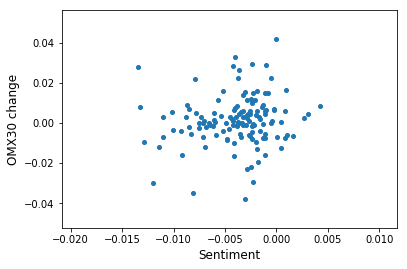

In [78]:
# plot the stock market change against sentiment variable

plt.scatter(complete_df['Average tone ratio'], complete_df['dif frac'])

plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('OMX30 change', fontsize=12)

plt.show

plt.savefig('sentiment-omxcorr.png')

/Users/matias/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


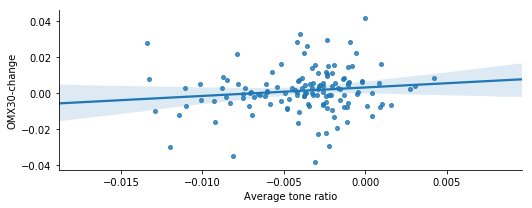

In [79]:
complete_df['OMX30-change'] = complete_df['dif frac']

sns.lmplot(x = 'Average tone ratio', y= 'OMX30-change', data = complete_df, height = 3, aspect = 2.5)

plt.savefig('regplot.png')

### Model validation

## Machine learning Model

In [90]:
import pandas as pd, numpy as np, sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [91]:
#complete_df = complete_df.replace([np.inf, -np.inf], np.nan)
#complete_df = complete_df.dropna()

In [110]:
# slicing the data, we define two models that we want to compare and train different estimation techniques

X = complete_df.loc[ : , ['Average tone ratio', 'repoann']] # explanatory variables

Xs = complete_df.loc[ : , ['repoann']] # X_simple, the model uses only the repo rate announced to predict marke reactions

y = complete_df.loc[ : , ['dif frac']] # value to be predicted
#y = complete_df.loc[ : , ['dif +30d']]
#y = complete_df.loc[ : , ['dif +14d']]

In [111]:
X = X.values
y = y.values
Xs = Xs.values
#X_dumb = X_dumb.values

In [112]:
# Linear regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0) #split into training and test, random state to get the same output.

X_dumb = np.repeat(y_train.mean(), len(y), axis = None)

X_dumb = X_dumb.reshape(-1, 1)

X_dumb#train

pipe_lr = make_pipeline(PolynomialFeatures(include_bias = False),  #including/excluding the bias depends on our choice
                        StandardScaler())
                        #LinearRegression())

test_mse = []
train_mse = []
parameters = []
degrees = range(2)

for p in degrees:
    X_train_p = pipe_lr.fit_transform(X_train, y_train) # polynomial expansion and transformation of the data
    X_test_p = pipe_lr.transform(X_test) # transform takes the test data and rescles it
    reg = LinearRegression().fit(X_train_p, y_train) 
    train_mse += [mse(reg.predict(X_train_p),y_train)] 
    test_mse += [mse(reg.predict(X_test_p),y_test)]     
    parameters.append(reg.coef_)
    
print(parameters)

[array([[ 0.00115556,  0.00460931, -0.00013627,  0.00047748, -0.00320995]]), array([[ 0.00115556,  0.00460931, -0.00013627,  0.00047748, -0.00320995]])]


In [113]:
train_mse, test_mse

([0.00015038126877854304, 0.00015038126877854304],
 [0.0001430590264158203, 0.0001430590264158203])

In [114]:
# create and split development set into validation and training

# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3), so divide by half!
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

# repeat the same for the simple model

# splitting into development (2/3) and test data (1/3)
Xs_dev, Xs_test, ys_dev, ys_test = train_test_split(Xs, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3), so divide by half!
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs_dev, ys_dev, test_size=1/2, random_state=1)

# repeat for the dumb model

# splitting into development (2/3) and test data (1/3)
X_dumb_dev, X_dumb_test, y_dumb_dev, y_dumb_test = train_test_split(X_dumb, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3), so divide by half!
X_dumb_train, X_dumb_val, y_dumb_train, y_dumb_val = train_test_split(X_dumb_dev, y_dumb_dev, test_size=1/2, random_state=1)

In [97]:
#X_dumb_val

In [98]:
#PolynomialFeatures(include_bias=True).fit_transform(X)

In [107]:
y_train.mean()

-0.0044151382729582635

In [115]:
# Lasso model: we remove the bias, i.e. beta_0 and we estimate a parameter that improves the prediction
pipe_lr = make_pipeline(PolynomialFeatures(include_bias = True),  #including/excluding the bias depends on our choice
                        StandardScaler(),
                        LinearRegression())

perform = []
lambdas = np.logspace(-4, 4, 20)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias= True), #multiple pipelines
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train) # fit on training data
    y_pred = pipe_lasso.predict(X_val) # predict performance on validation set
    perform.append(np.sqrt(mse(y_pred, y_val))) # saved as a series of lambdas
    
hyperparam_perform = pd.Series(perform,index=lambdas)
hyperparam_perform.nsmallest(1) # select the smallest hyperparameter

optimal = hyperparam_perform.nsmallest(1)    
print('Optimal alpha:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# insert optimal  lambda in new model

pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0])) # new value..., alpha is lambda!
# fit new model on all development data, fit = estimate!
pipe_lasso.fit(X_dev,y_dev)
pipe_lr.fit(X_dev,y_dev)

# compare model performance on test data
print('Lasso', round(np.sqrt(mse(pipe_lasso.predict(X_test),y_test)), 7)) # smaller mse, better performance than linear model
print('LinReg', round(np.sqrt(mse(pipe_lr.predict(X_test),y_test)), 7))

#--------------------------------------------
# REPEAT THE ANALYSIS FOR THE 'SIMPLE' MODEL
#--------------------------------------------

perform_s = []
lambdas = np.logspace(-4, 4, 20)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias= True), #multiple pipelines
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(Xs_train, ys_train) # fit on training data
    ys_pred = pipe_lasso.predict(Xs_val) # predict performance on validation set
    perform_s.append(np.sqrt(mse(ys_pred, ys_val))) # saved as a series of lambdas
    
hyperparam_perform_s = pd.Series(perform_s,index=lambdas)
hyperparam_perform_s.nsmallest(1) # select the smallest hyperparameter

optimal_s = hyperparam_perform_s.nsmallest(1)    
print('Optimal alpha univariate model:', optimal_s.index[0])
print('Validation RMSE univariate model: %.3f' % optimal_s.values[0])

# insert optimal  lambda in new model

pipe_lasso_s = make_pipeline(PolynomialFeatures(include_bias=True), 
                           StandardScaler(),
                           Lasso(alpha=optimal_s.index[0])) # new value..., alpha is lambda!
# fit new model on all development data, fit = estimate!
pipe_lasso_s.fit(Xs_dev,ys_dev)
pipe_lr.fit(Xs_dev,ys_dev)

# compare model performance on test data
print('Lasso univariate model', round(np.sqrt(mse(pipe_lasso_s.predict(Xs_test), ys_test)), 6)) # smaller mse, better performance than linear model
print('LinReg univariate model', round(np.sqrt(mse(pipe_lr.predict(Xs_test), ys_test)), 6))

# -------------------------
# Repeat for dumb model
# -------------------------

#X_dumb_train = X_dumb_train.reshape(-1,1)

perform_dumb = []
lambdas = np.logspace(-4, 4, 20)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias= False), #multiple pipelines
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_dumb_train, y_dumb_train) # fit on training data
    y_dumb_pred = pipe_lasso.predict(X_dumb_val) # predict performance on validation set
    perform_dumb.append(np.sqrt(mse(y_dumb_pred, y_dumb_val))) # saved as a series of lambdas
    
hyperparam_perform_dumb = pd.Series(perform_dumb,index=lambdas)
hyperparam_perform_dumb.nsmallest(1) # select the smallest hyperparameter

optimal_dumb = hyperparam_perform_dumb.nsmallest(1)    
print('Optimal alpha simple model:', optimal_dumb.index[0])
print('Validation RMSE simple model: %.3f' % optimal_dumb.values[0])

# insert optimal  lambda in new model

pipe_lasso_dumb = make_pipeline(PolynomialFeatures(include_bias=False), 
                           StandardScaler(),
                           Lasso(alpha=optimal_dumb.index[0])) # new value..., alpha is lambda!
# fit new model on all development data, fit = estimate!
pipe_lasso_dumb.fit(X_dumb_dev,y_dumb_dev)
pipe_lr.fit(X_dumb_dev,y_dumb_dev)

# compare model performance on test data
print('Lasso simple model', round(np.sqrt(mse(pipe_lasso_dumb.predict(X_dumb_test),y_dumb_test)), 6)) # smaller mse, better performance than linear model
print('LinReg simple model', round(np.sqrt(mse(pipe_lr.predict(X_dumb_test),y_dumb_test)), 6))


Optimal alpha: 0.0018329807108324356
Validation MSE: 0.011
Lasso 0.0101702
LinReg 0.0106166
Optimal alpha univariate model: 0.0001
Validation RMSE univariate model: 0.012
Lasso univariate model 0.010023
LinReg univariate model 0.009879
Optimal alpha simple model: 0.0001
Validation RMSE simple model: 0.012
Lasso simple model 0.009934
LinReg simple model 0.009934


In [101]:
#perform_s

### Model validation

In [102]:
pipe_lasso.fit(X_dev, y_dev)
pipe_lasso.predict(X_test)

array([0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815,
       0.00058815, 0.00058815, 0.00058815, 0.00058815, 0.00058815])

In [103]:
# Measures for accuracy r2_score??
from sklearn.metrics import r2_score

pipe_lasso.fit(X_dev, y_dev)
#pipe_lasso.predict(X_test)

y_pred = pipe_lasso.predict(X_test)

print(r2_score(y_test, y_pred))



-0.07408443921518937


In [169]:
pipe_lasso.fit(Xs_dev, ys_dev)
#pipe_lasso.predict(Xs_test)

ys_pred = pipe_lasso.predict(Xs_test)

print(r2_score(ys_test, ys_pred))


-0.018899367178471183


lambda
0.004833    0.000232
Name: Validation, dtype: float64


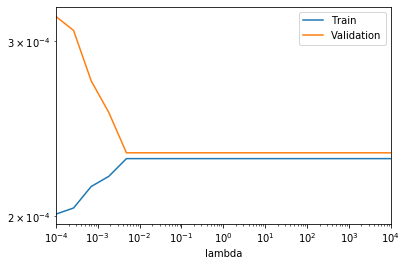

In [104]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

mse_score.plot(logx=True, logy=True) # optimal hyperparameters

# Wordcloud

(-0.5, 1279.5, 719.5, -0.5)

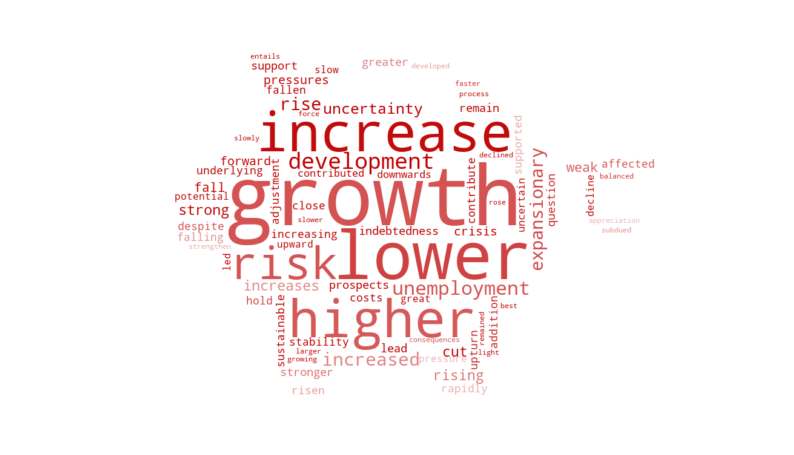

In [45]:
# Wordcloud using masking

wc_mask = np.array(Image.open(r'C:\Users\sebag\Documents\GitHub\Wordcloud_test_red.png').convert('RGB'))
#wc_mask = np.array(Image.open(r'C:\Users\sebag\Documents\GitHub\SDS Group 35\sveriges_riksbank_2_png.png').convert('RGB'))

wc = WordCloud(background_color="white",\
               width=2000,height=1300,\
               relative_scaling=0.5,\
               normalize_plurals=False, random_state=2, mask = wc_mask).generate_from_frequencies(count_dict)

image_colors = ImageColorGenerator(wc_mask)

plt.figure(figsize = [10, 10])
plt.imshow(wc.recolor(color_func = image_colors), interpolation = 'bilinear')
plt.axis("off")
#plt.savefig('Wordcloud_piggybank_red.png')